<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/msch_kNN_SVM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extended Project 1: $k$-Nearest Neighbours & Support Vector Machines**

---



Course: Computation Machine Learning II

Submission Date: Feb 20, 2022

Student: Mathias Schindler

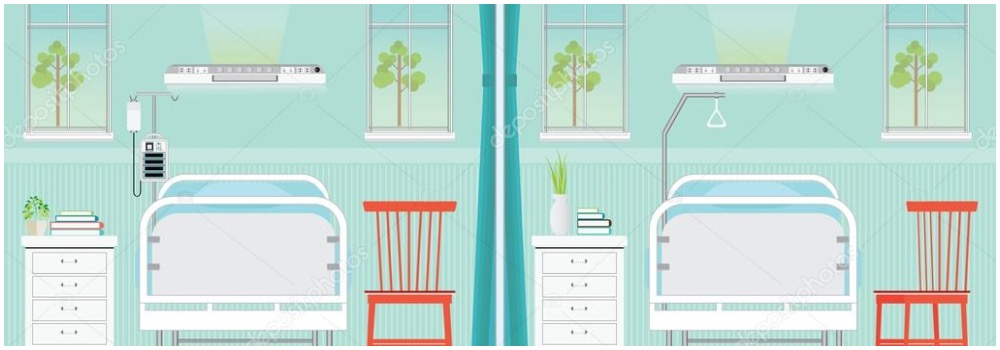

## Instructions

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# **0. Preamble**

In [1]:
# clear everything
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [2]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2/Project1_kNN')

In [4]:
!ls

comorb_test.ipynb  mschindler_functions_v5.py	old_scripts  schindlerlib
data		   msch_kNN_mano-pipline.ipynb	preds	     utils
extra_data	   msch_kNN_SVM_final.ipynb	__pycache__


In [5]:
# Install skopt from Github (for Bayesian optimization over hyper parameters)
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-xmd5dbph
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-xmd5dbph
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=a728ea9caaad274715809bba6639995ce15cc76517de69984035b73c6c51adbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-nessvxnm/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize


In [6]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 395 kB/s 


In [7]:
# Load libraries

# Core libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# For date format handling
from datetime import datetime, timedelta

# scikit-learn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

# oversampling for class imbalance
from imblearn.over_sampling import RandomOverSampler 

# Bayesian optimizer for hyperparamters
from skopt import BayesSearchCV

# Category encoder
import category_encoders as ce
from category_encoders.woe import WOEEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# import Jack's custom functions
from utils import helper_functions as util
print(dir(util))

['GridSearch_table_plot', 'Plot_Point', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'colors', 'get_auc', 'np', 'pd', 'plot_any_cat_matrix', 'plot_boundaries_iris_dataset', 'plot_confusion_matrix', 'plot_digits_sample', 'plot_svc_decision_function', 'plt', 'random', 'roc_auc_score', 'roc_curve', 'sklearn', 'sns']


In [9]:
# import my custom functions
from schindlerlib.plots import schindler_plots as my_plots
from schindlerlib.preproz import schindler_preproz as my_preproz
from schindlerlib.postest import schindler_postest as my_postest

print(dir(my_plots)); print(dir(my_preproz)); print(dir(my_postest))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_feat_importance_plot', 'make_nan_fig', 'make_roc_plot', 'make_scree_plot', 'missing_plot', 'np', 'p_hat_plot', 'pd', 'plot_confusion_matrix', 'plt', 'sns']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'construct_age_admit', 'datetime', 'np', 'pd', 'timedelta']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_multi_point_pred', 'np', 'pd', 'reweight', 'reweight_proba_multi']


# **1. Exploratory Data Analysis**

## 1.1 Load Data

In [10]:
# Load data
df_train = pd.read_csv("data/mimic_train.csv", index_col=3)
df_test = pd.read_csv("data/mimic_test_death.csv", index_col=2)

In [11]:
# Remove identifier variables
#id_vars = ['subject_id', 'hadm_id']
id_vars = ['hadm_id']

df_train = df_train.drop(id_vars, axis = 1)
df_test = df_test.drop(id_vars, axis = 1)

## 1.2 Data Types

In [12]:
# Check data types in datasets
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIME                object
DISCHTIME                object
DEATHTIM

Variables `GENDER`, `DOB`, `ADMITTIME`, `ADMISSION_TYPE`, `INSURANCE`, `RELIGION`, `MARITAL_STATUS`, `ETHNICITY`, `DIAGNOSIS`, `ICD9_diagnosis`, `FIRST_CAREUNIT` are string/categorical.


## 1.3 Missing Data Exploration

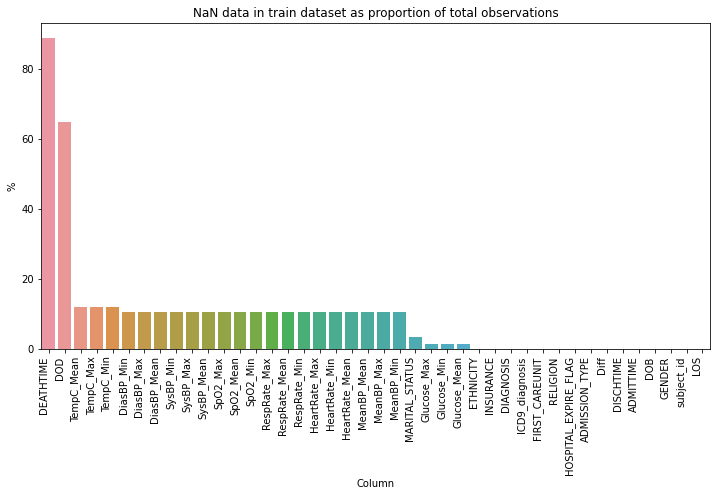

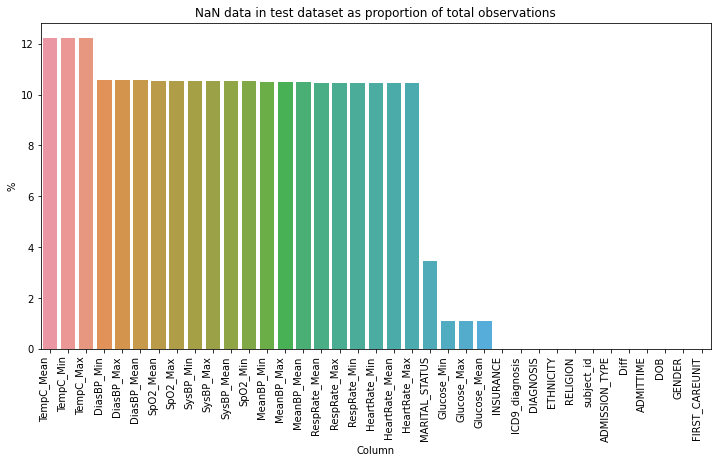

In [13]:
my_plots.missing_plot(df_train, 'train'); my_plots.missing_plot(df_test, 'test')

## 1.4 Feature Distribution

### 1.4.1 Univariate Distributions of Numerical Features

In [14]:
# Save numerical features as list
cols_list = df_train.columns.to_list()
cols_list_str =  ['GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 
                  'FIRST_CAREUNIT']
cols_list_nostr = [var for var in cols_list if var not in cols_list_str]

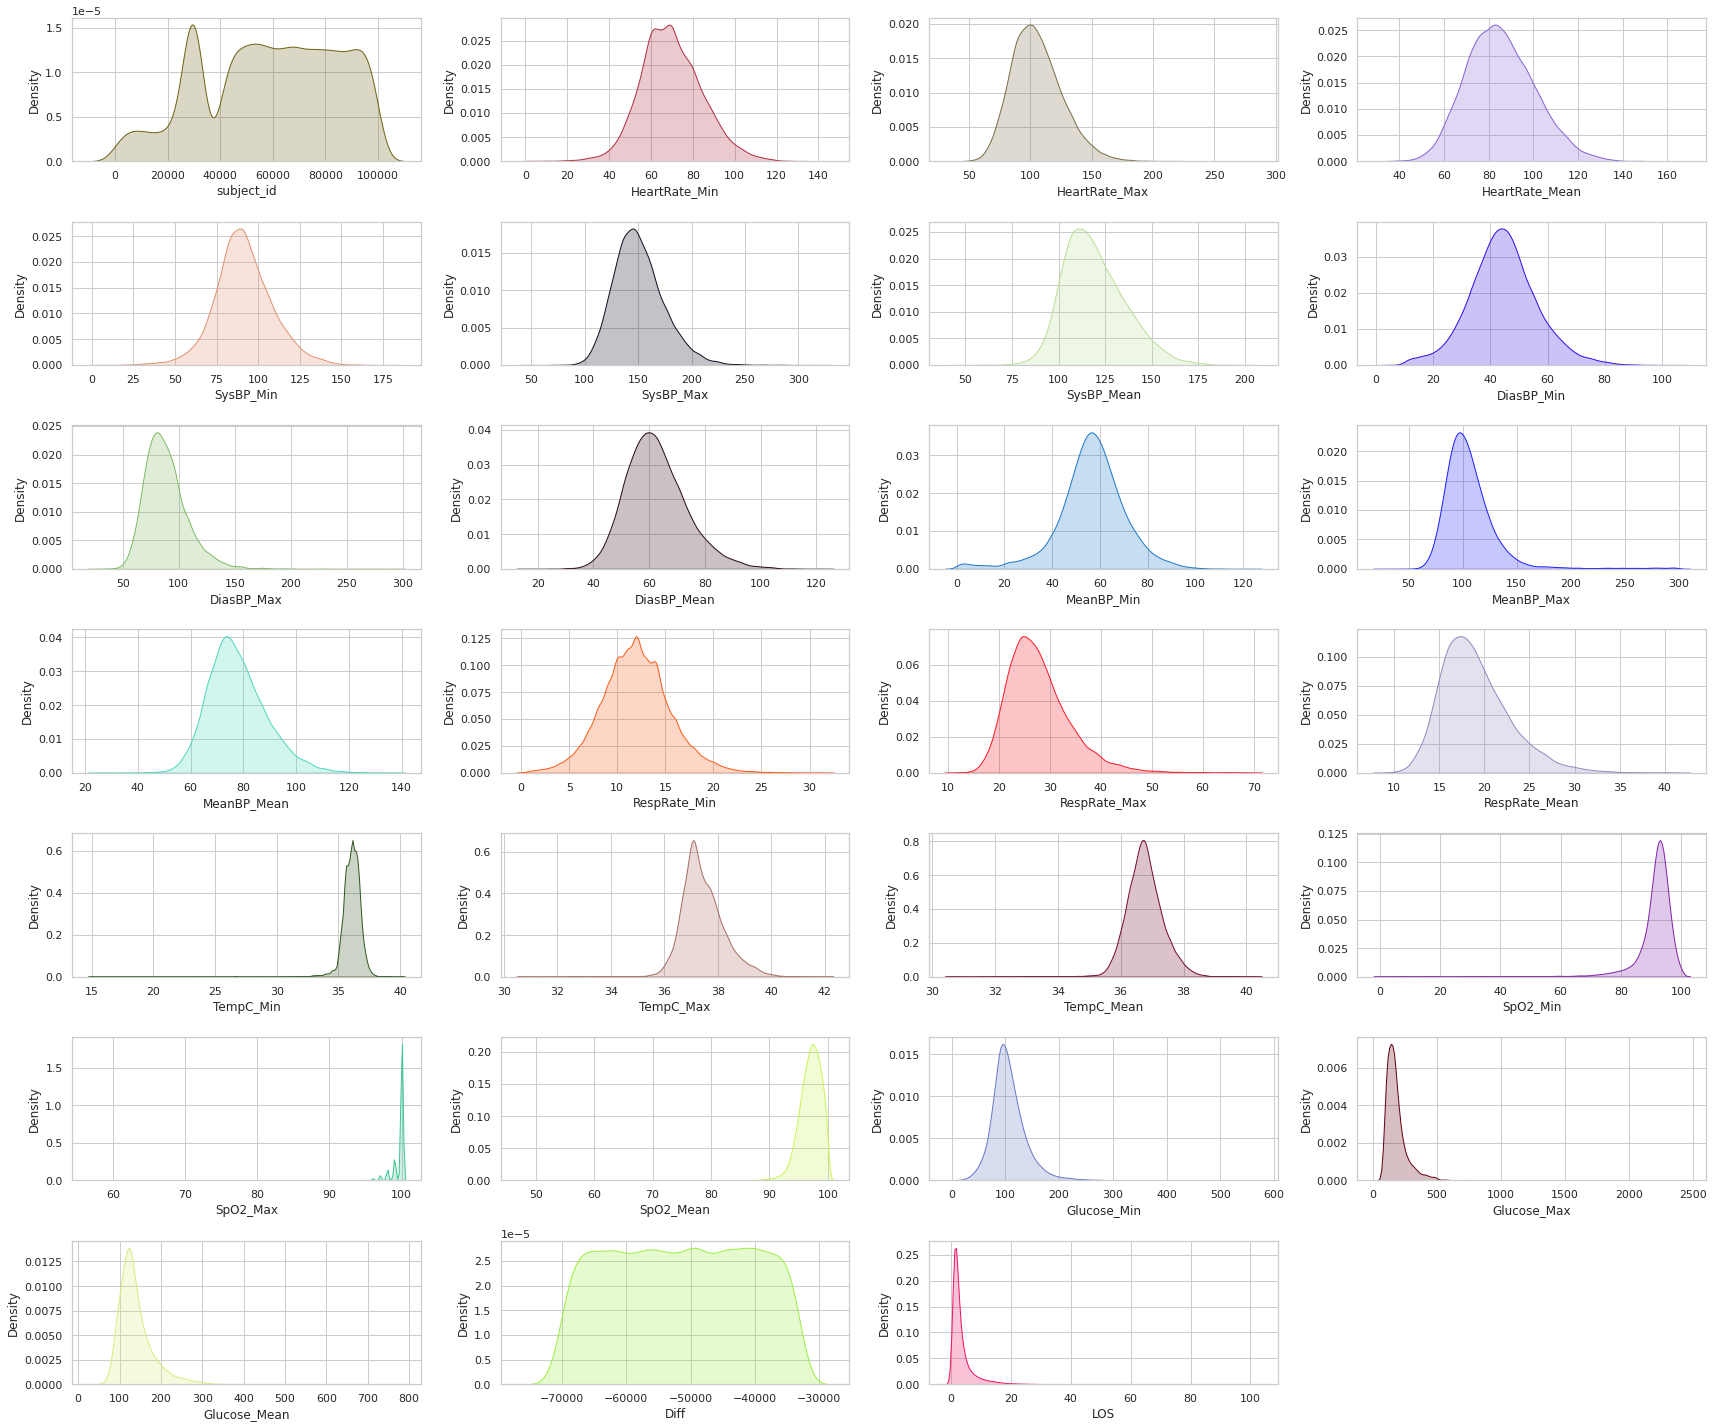

In [15]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(24, 20)) # Size of the matrix plots

for i, col in enumerate(cols_list_nostr):
  if i == 0:
    pass
  else:
    plt.subplot(7, 4, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df_train, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

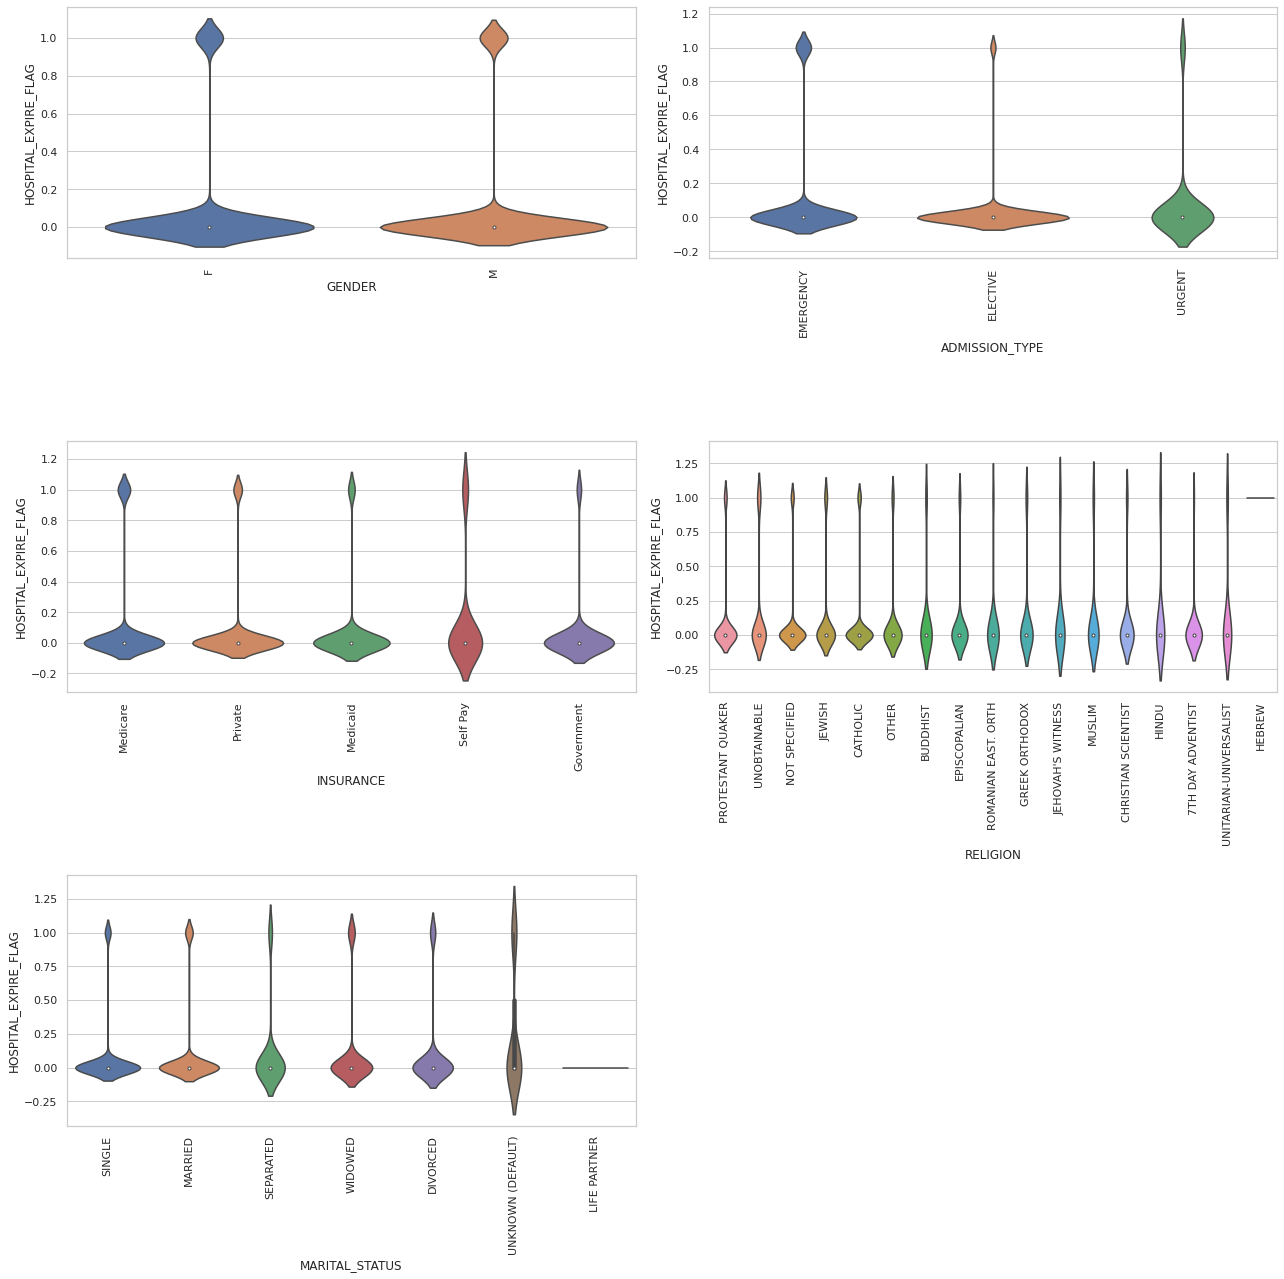

In [16]:
# Univariate violin plot distributions for categorical features
sns.set(style="whitegrid")
plt.figure(figsize=(18, 40)) # Size of the matrix plots
lst = [0, 6, 7, 8, 9]

k = 1
for i in lst:
  plt.subplot(7, 2, k) # row, cols and i is the element to plot
  sns.violinplot(x = cols_list_str[i], y = 'HOSPITAL_EXPIRE_FLAG', data = df_train )
  plt.xticks(rotation=90)
  k += 1

plt.tight_layout()

### 1.4.2 Multivariate Distributions

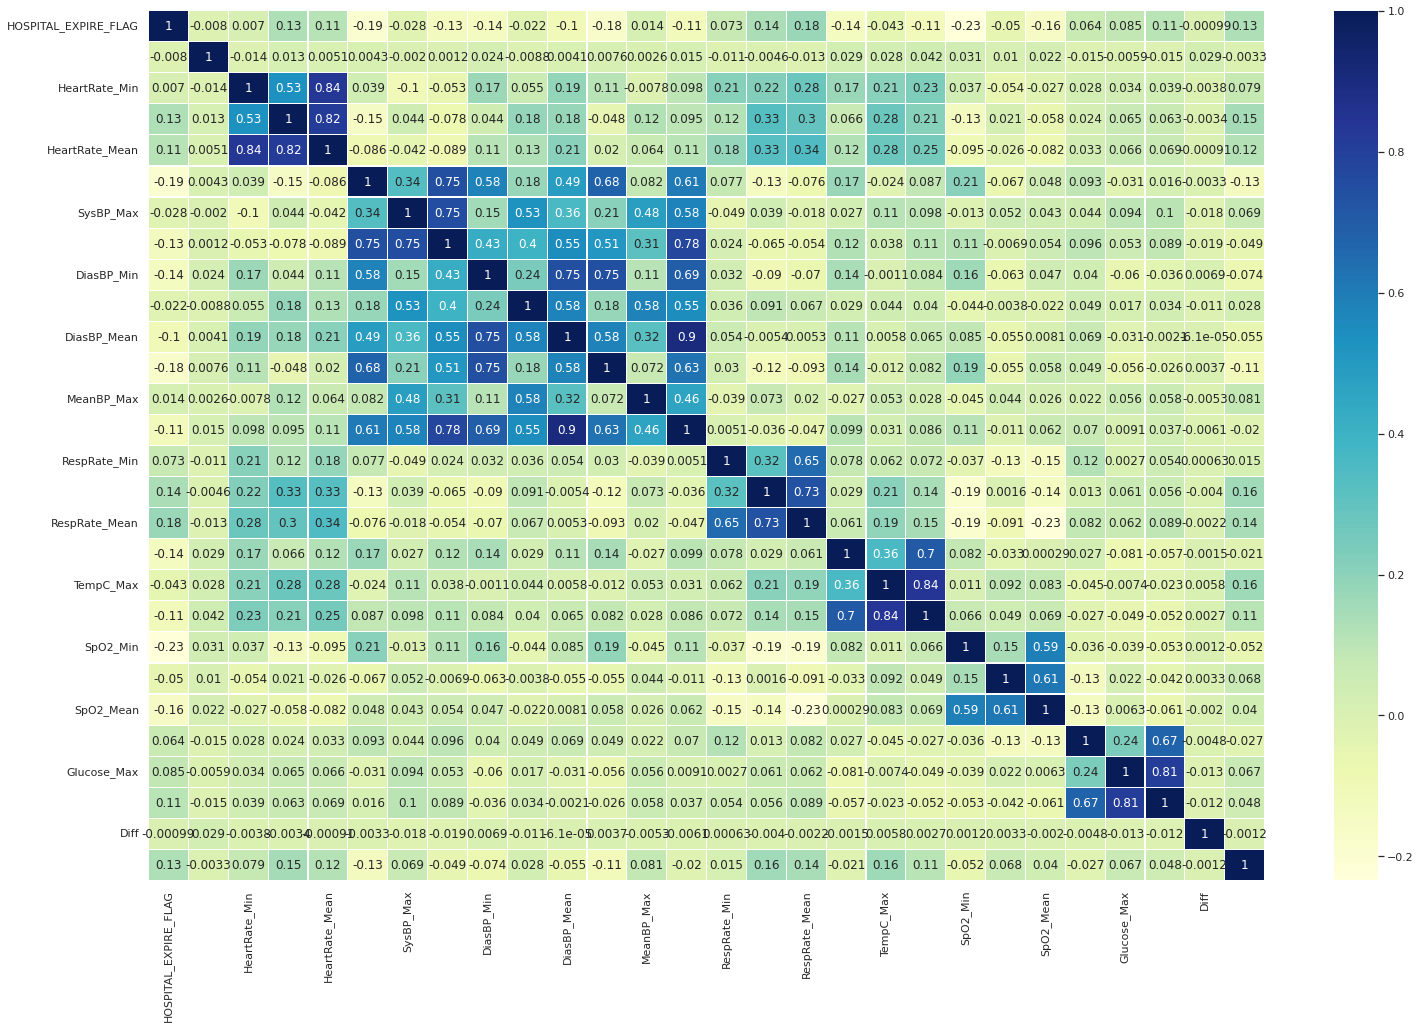

In [17]:
# Heatmap
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap="YlGnBu", 
            linecolor='white', 
            annot=True)

fig = plt.gcf()
fig.set_size_inches(25, 16)

# **2. Feature Engineering**

## 2.1 Age-at-Admission Variable

### 2.1.1 Format Age Variables using `datetime`

Format admission datetime (see custom functions in external `.py`-file with custom functions).

In [18]:
%%time
df_train_age = my_preproz.construct_age_admit(df_train)
df_test_age = my_preproz.construct_age_admit(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


CPU times: user 23.7 s, sys: 421 ms, total: 24.1 s
Wall time: 23.6 s


### 2.1.2 Inspect Constructed Age Variables

In [19]:
# Check if missing values were generated
print(df_train_age['age_at_admin'].isnull().any() )
print(df_test_age['age_at_admin'].isnull().any() )

False
False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


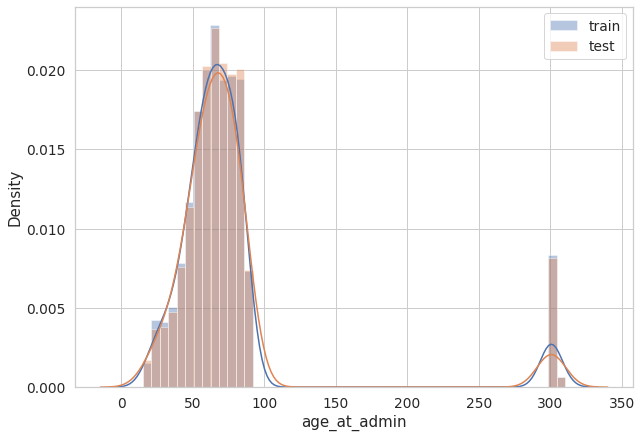

In [20]:
# Check distribution

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train')
sns.distplot(df_test_age['age_at_admin'], label='test')

# Add legend
plt.legend()

In [21]:
# Save correct ages (for later comparison)
orig_age_train = df_train_age[df_train_age['age_at_admin'] < 250]
orig_age_test = df_test_age[df_test_age['age_at_admin'] < 250]

In [22]:
#Counts of >100-year-olds 
print("No. of individuals in train more than 100 years old: " + str(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in train for those >100 years:")
print(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

print("\n")

print("No. of individuals in test more than 100 years old: " + str(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in test for those >100 years:")
print(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals in train more than 100 years old: 1107

 Value counts in train for those >100 years:
299.994524    795
300.054757      4
300.021903      3
300.049281      3
301.648186      3
             ... 
300.487337      1
300.514716      1
301.530459      1
301.215606      1
300.788501      1
Name: age_at_admin, Length: 270, dtype: int64


No. of individuals in test more than 100 years old: 270

 Value counts in test for those >100 years:
299.994524    201
300.027379      2
304.859685      2
310.272416      1
304.262834      1
             ... 
300.202601      1
301.059548      1
304.150582      1
302.592745      1
300.539357      1
Name: age_at_admin, Length: 68, dtype: int64


So, those individuals over 100 years old are calculated to be between 299 to 303 years old. Seems quite unrealistic. In order to not delete observations (and for a lack of better alternative) these values are replaced by the median.

### 2.1.3 Clean Constructed Age Variables

In [23]:
# Set >100 year olds to NaN
df_train_age.loc[df_train_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_test_age.loc[df_test_age.age_at_admin >= 100, 'age_at_admin'] = np.nan

# Print counts of new NaNs
print("# >100 year-olds in train: ", df_train_age['age_at_admin'].isna().sum())
print("# >100 year-olds in test: ", df_test_age['age_at_admin'].isna().sum())

# >100 year-olds in train:  1107
# >100 year-olds in test:  270


In [24]:
# Set numerical data frame
feats_train = df_train_age.drop(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 
                    'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'ICD9_diagnosis',
                    'DOD', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], 
                   axis = 1)
feats_test = df_test_age.drop(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 
                    'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'ICD9_diagnosis'], 
                   axis = 1)


# Set list of index for individuals w. >100 year-olds
age_na_train = feats_train[feats_train['age_at_admin'].isnull()].index.tolist()
age_na_test = feats_test[feats_test['age_at_admin'].isnull()].index.tolist()

I also add my auxiliary comorbidities dataset as I suspect this might help with $k$-NN imputation. Please refer to Sections 2.2 and 3.4 for further explanations about construction methodology of comobidity information.

In [25]:
# Load prepared comorbidities dataset
comorb_url = "https://raw.githubusercontent.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/main/Project-1-kNN/data/comorb_final-2022-02-08-10-52.csv"
comorb = pd.read_csv(comorb_url, index_col=0)
comorb_add = comorb.drop('charlson_score', axis = 1)

# Merge
feats_train = feats_train.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)
feats_test = feats_test.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)

# Drop unnecesary cols
feats_train = feats_train.drop(['subject_id', '_merge'], axis = 1)
feats_test = feats_test.drop(['subject_id', '_merge'], axis = 1)

# Reset index
# Set indices from X_train and X_train respectively
feats_train = feats_train.set_index(df_train_age.index)
feats_test = feats_test.set_index(df_test_age.index)

#Inspect
feats_test.head(3)
feats_train.head(3)

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,69.560575,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,42.072553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,68.164271,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0


In [26]:
%%time
# Instantiate imputer
knn_imput = KNNImputer(n_neighbors = 1000)

# Fit
knn_imput.fit(feats_train)

# Transform
age_train_knn = knn_imput.transform(feats_train)
age_test_knn = knn_imput.transform(feats_test)

# Make pd.DataFrame
age_train_knn = pd.DataFrame(age_train_knn, 
                    columns = knn_imput.feature_names_in_,
                    index = feats_train.index)
age_test_knn = pd.DataFrame(age_test_knn, 
                    columns = knn_imput.feature_names_in_,
                    index = feats_test.index)

# Value counts 
print('Train: \n', age_train_knn['age_at_admin'].loc[age_na_train].value_counts()); print("\n")
print('Test: \n', age_test_knn['age_at_admin'].loc[age_na_test].value_counts())

Train: 
 66.178086    1
64.882185    1
66.085925    1
63.090385    1
63.754533    1
            ..
61.398850    1
66.390976    1
60.628364    1
62.184003    1
57.729437    1
Name: age_at_admin, Length: 1107, dtype: int64


Test: 
 63.938204    1
62.325144    1
66.101175    1
64.016235    1
59.295151    1
            ..
63.780523    1
64.680548    1
62.714272    1
62.524271    1
63.497347    1
Name: age_at_admin, Length: 270, dtype: int64
CPU times: user 44.9 s, sys: 1.59 s, total: 46.5 s
Wall time: 44.7 s


In [27]:
# Overwrite original 'age_at_admin' with new k-NN-imputed age variables in original datasets
df_train_age['age_at_admin'] = age_train_knn['age_at_admin']
df_test_age['age_at_admin'] = age_test_knn['age_at_admin']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


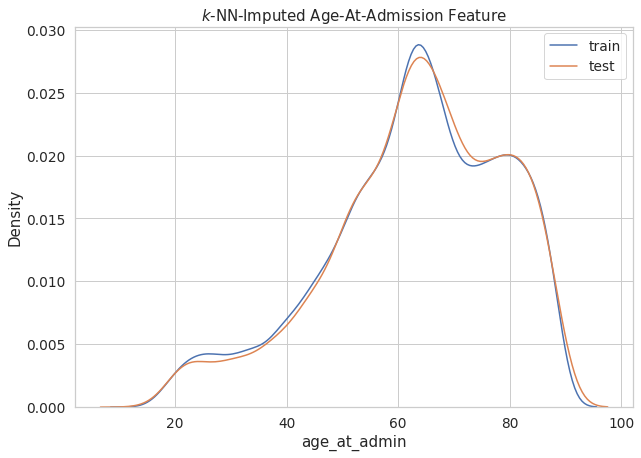

In [28]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train', hist = False)
sns.distplot(df_test_age['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()
plt.title("$k$-NN-Imputed Age-At-Admission Feature")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


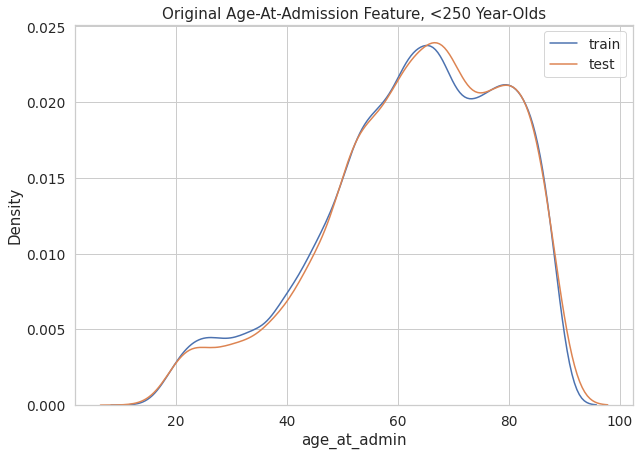

In [29]:
# Check distribution for previous <250 year-olds (for comparison)

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(orig_age_train['age_at_admin'], label='train', hist = False)
sns.distplot(orig_age_test['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()
plt.title("Original Age-At-Admission Feature, <250 Year-Olds")
plt.show()

## 2.2 Co-Morbitidity Information

Please refer to the auxiliary notebook `comorb_transform.ipynb` ([this GitHub-link](https://github.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/comorb_transform.ipynb)) where comorbidities are transformed using the `icd` package in `R`. Also Section 3.4 where the comorbodities are merged to the main dataset. Here I mainly present my auxiliary constructed dataset with comorbidities as this is a part of the feature engineering process.

In [30]:
comorb_url = "https://raw.githubusercontent.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/main/Project-1-kNN/data/comorb_final-2022-02-08-10-52.csv"
comorb = pd.read_csv(comorb_url, index_col=0)
comorb

,subject_id,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,charlson_score
1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1000,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,5
4,10000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,6
5,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46516,9999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
46517,99991,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
46518,99992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46519,99995,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3


# **3. Preprocessing Data**

## 3.0 Compare Features in Train and Test

Compare features in both data sets

In [31]:
df_train_fillna, df_test_fillna = df_train_age, df_test_age

In [32]:
print("Features in train data but not in test:")
print(df_train_fillna.columns.difference(df_test_fillna.columns) )

print("\n Features in test data but not in train:")
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Features in train data but not in test:
Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


In [33]:
# Remove features in train that are not in test (except target 'HOSPITAL_EXPIRE_FLAG')
df_train_fillna = df_train_fillna.drop(['DISCHTIME', 'LOS', 'DEATHTIME', 'DOD',], axis = 1)

In [34]:
print(df_train_fillna.columns.difference(df_test_fillna.columns) )
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Index(['HOSPITAL_EXPIRE_FLAG'], dtype='object')
Index([], dtype='object')


## 3.1 Inspect Missing Values

To be dealt with later in Sections 3.1.3 and 3.2.5

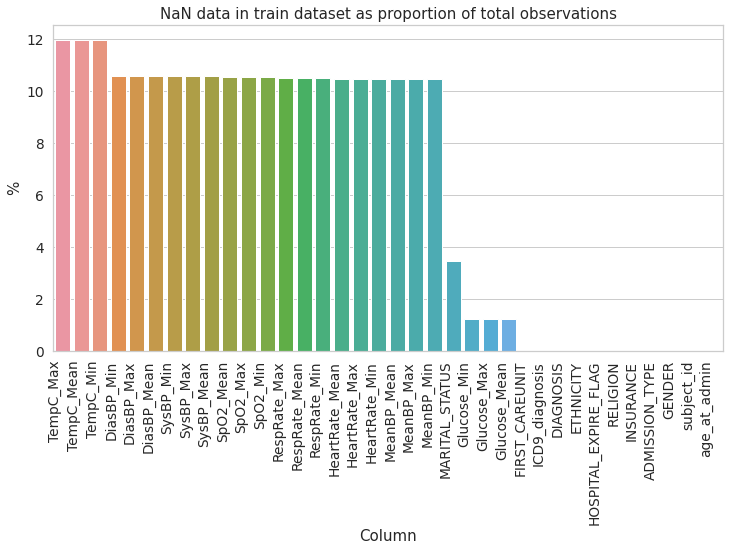

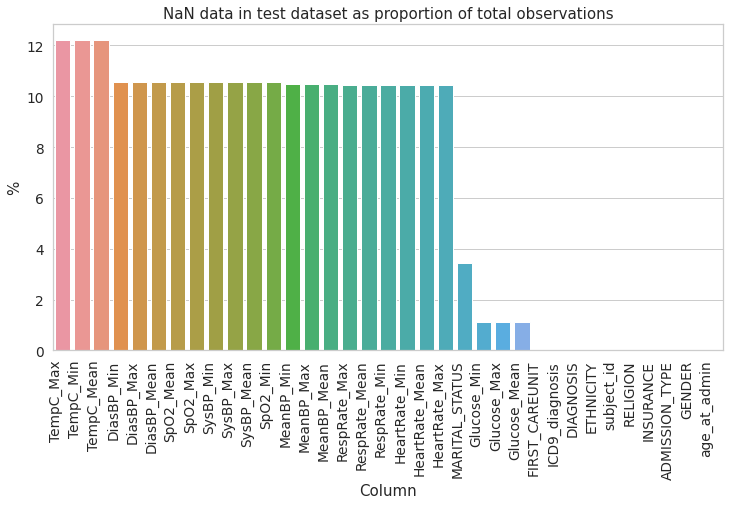

In [35]:
# Investigate missing data
my_plots.missing_plot(df_train_fillna, 'train'); my_plots.missing_plot(df_test_fillna, 'test')

## 3.2 Split Categorical and Numerical Data

In [36]:
# Numerical Data
cat_feats = ["subject_id", "GENDER", "ADMISSION_TYPE", "INSURANCE", "FIRST_CAREUNIT", "MARITAL_STATUS", "RELIGION",
             "ETHNICITY", "ICD9_diagnosis", "DIAGNOSIS"]

df_train_num = df_train_fillna.drop(cat_feats, axis = 1)
df_test_num = df_test_fillna.drop(cat_feats, axis = 1)

In [37]:
# Categorical Data
df_train_cat = df_train_fillna[cat_feats]
df_train_cat = df_train_cat.drop("subject_id", axis = 1)

df_test_cat = df_test_fillna[cat_feats]
df_test_cat = df_test_cat.drop("subject_id", axis = 1)

In [38]:
# Split target
y_train = df_train_fillna['HOSPITAL_EXPIRE_FLAG']
df_train_num = df_train_num.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

Compare again

In [39]:
# Compare numerical features
print(df_train_num.columns.difference(df_test_num.columns) )
print(df_test_num.columns.difference(df_train_num.columns) )

Index([], dtype='object')
Index([], dtype='object')


In [40]:
# Compare categorical features
print(df_train_cat.columns.difference(df_test_cat.columns) )
print(df_test_cat.columns.difference(df_train_cat.columns) )

Index([], dtype='object')
Index([], dtype='object')


## 3.3 Numerical Features 

### 3.3.1 Polynomial Transformations

I have tried running the estimation process with polynomial transformations but the increase in estimated accuracy does not warrant the increase in dimensions.

In [41]:
'''
# Set degree  and save column names
degree = 2 


# Instantiate
poly = plf(degree, include_bias = False)

# Fit 
poly.fit(df_train_num)

# Save polynomial column names
poly_col_names = poly.get_feature_names(df_train_num.columns)

# Transform data
df_train_poly, df_test_poly = poly.transform(df_train_num), poly.transform(df_test_num)

# Dataframes
df_train_poly = pd.DataFrame(df_train_poly, 
                             columns = poly_col_names, 
                             index = df_train_num.index)
df_test_poly = pd.DataFrame(df_test_poly, 
                            columns = poly_col_names, 
                            index = df_test_num.index)
'''

'\n# Set degree  and save column names\ndegree = 2 \n\n\n# Instantiate\npoly = plf(degree, include_bias = False)\n\n# Fit \npoly.fit(df_train_num)\n\n# Save polynomial column names\npoly_col_names = poly.get_feature_names(df_train_num.columns)\n\n# Transform data\ndf_train_poly, df_test_poly = poly.transform(df_train_num), poly.transform(df_test_num)\n\n# Dataframes\ndf_train_poly = pd.DataFrame(df_train_poly, \n                             columns = poly_col_names, \n                             index = df_train_num.index)\ndf_test_poly = pd.DataFrame(df_test_poly, \n                            columns = poly_col_names, \n                            index = df_test_num.index)\n'

In [42]:
# When not running poly transformation
df_train_poly, df_test_poly = df_train_num, df_test_num

### 3.3.2 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [43]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to train 
scaler.fit(df_train_poly)

# Transform train and test
df_train_scl = scaler.transform(df_train_poly)
df_test_scl = scaler.transform(df_test_poly)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, 
                            columns = df_train_poly.columns, 
                            index = df_train_poly.index)
df_test_scl = pd.DataFrame(df_test_scl, 
                           columns = df_test_poly.columns, 
                           index = df_test_poly.index)

### 3.3.3 Imputing NaNs

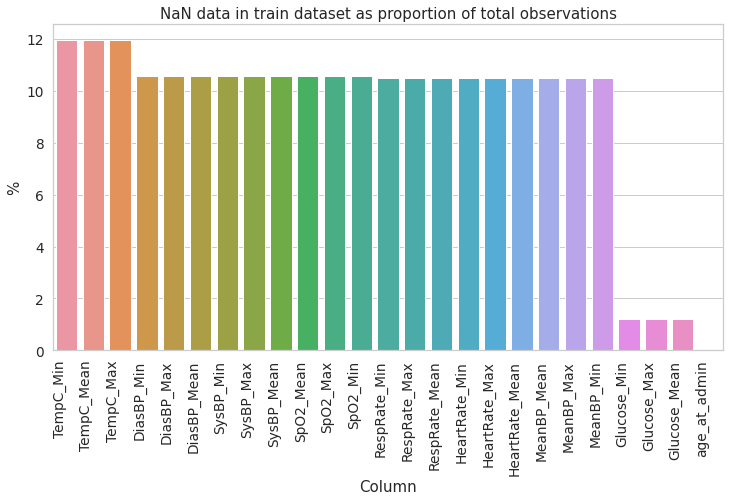

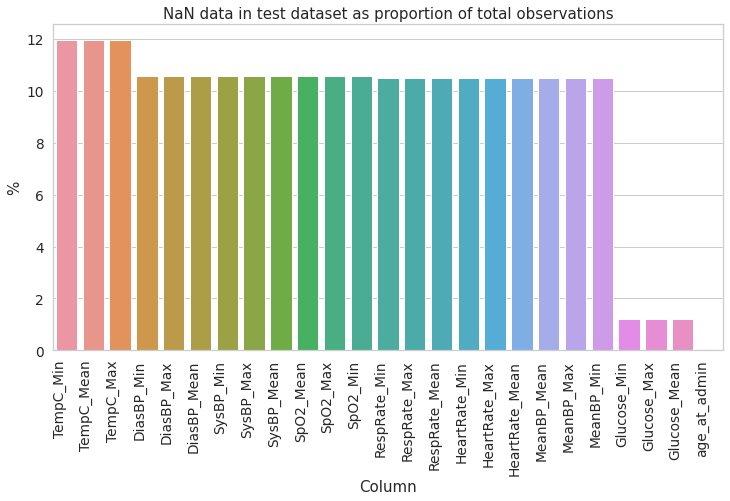

In [44]:
# Investigate missing data
my_plots.missing_plot(df_train_scl, 'train'); my_plots.missing_plot(df_train_scl, 'test')

I use the `IterativeImputer` from `sklearn.experimental` as this has yielded me the best results.

In [45]:
%%time
#Instantiate imputer
imp_nums = IterativeImputer(random_state = 0)

# Fit
imp_nums.fit(df_train_scl)

# Transform
df_train_scl = imp_nums.fit_transform(df_train_scl)
df_test_scl = imp_nums.transform(df_test_scl)

# pd.DataFrames
df_train_scl = pd.DataFrame(df_train_scl,
                            columns = df_train_poly.columns,
                            index = df_train_poly.index)
df_test_scl = pd.DataFrame(df_test_scl,
                            columns = df_test_poly.columns,
                            index = df_test_poly.index)

# Inspect
print(df_train_scl.isna().any()); print(df_test_scl.isna().any())

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
age_at_admin      False
dtype: bool
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
Temp

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


## 3.4 Categorical Features

### 3.4.1 Exploration

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE`, `MARITAL_STATUS` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality, while having a not-too-large number of categories (so dimensionality does not explode).

In [46]:
cat_feats.remove('subject_id')

In [47]:
# Count number of categories for each categorical feature
print("#Categories in each categorical feature\n")
for c in cat_feats:
  print(str(c) + ": " + str(df_train_cat[c].nunique(dropna = False))); print("\n")

#Categories in each categorical feature

GENDER: 2


ADMISSION_TYPE: 3


INSURANCE: 5


FIRST_CAREUNIT: 5


MARITAL_STATUS: 8


RELIGION: 17


ETHNICITY: 41


ICD9_diagnosis: 1853


DIAGNOSIS: 6193




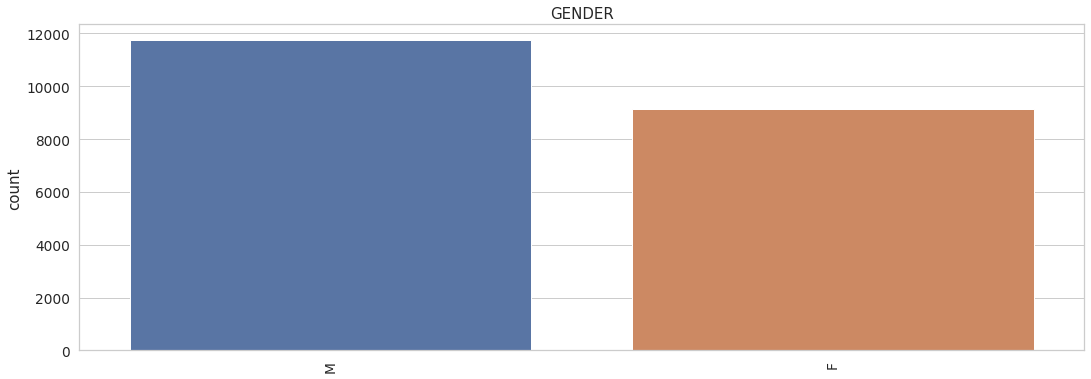

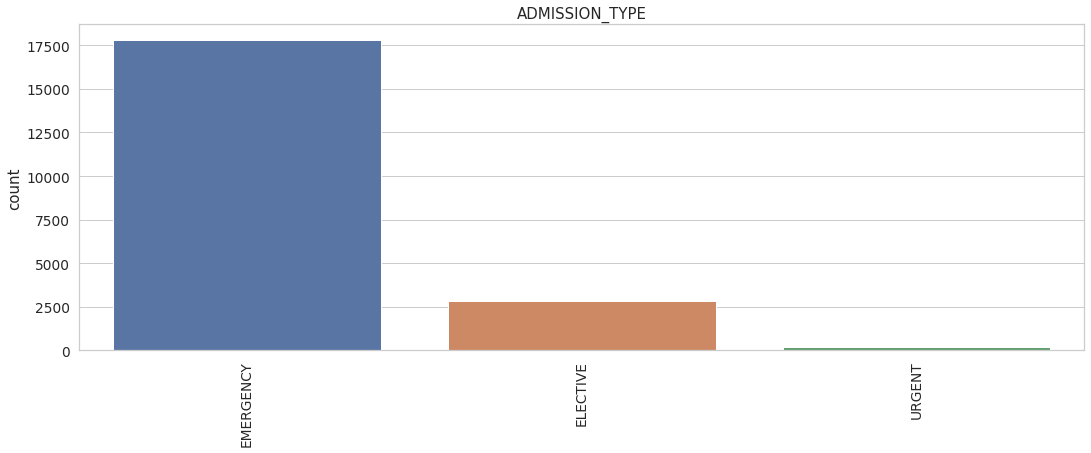

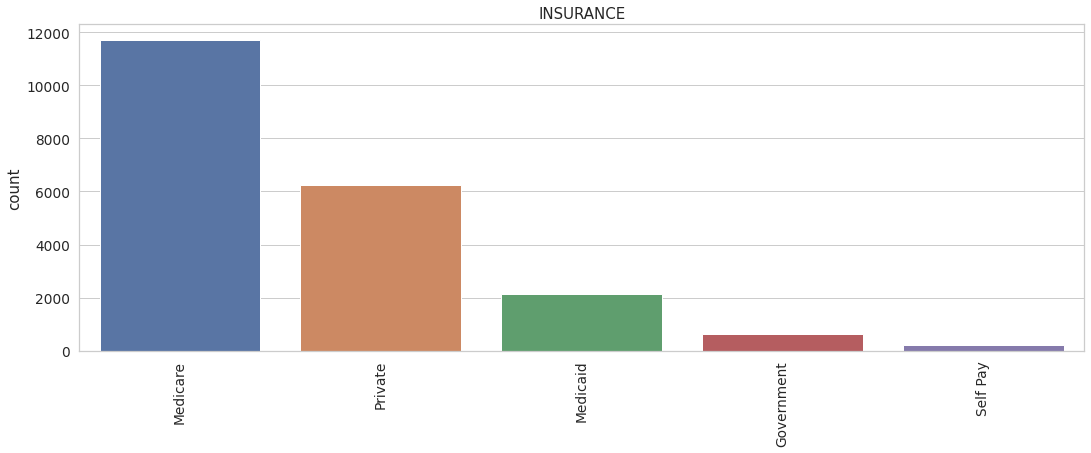

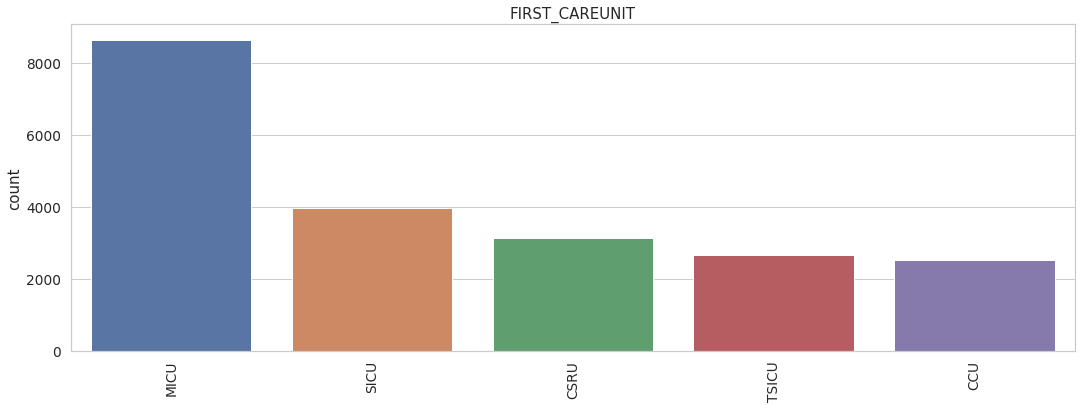

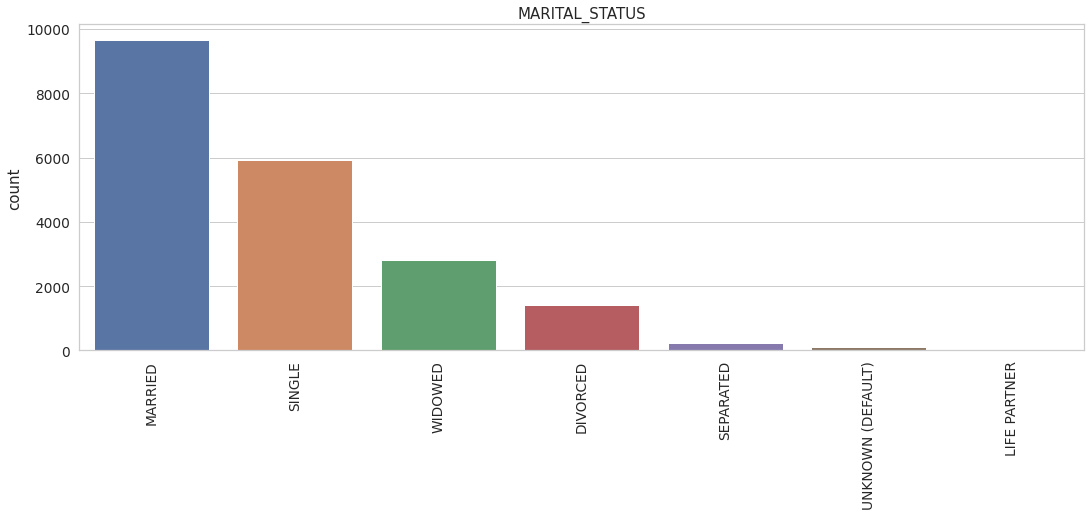

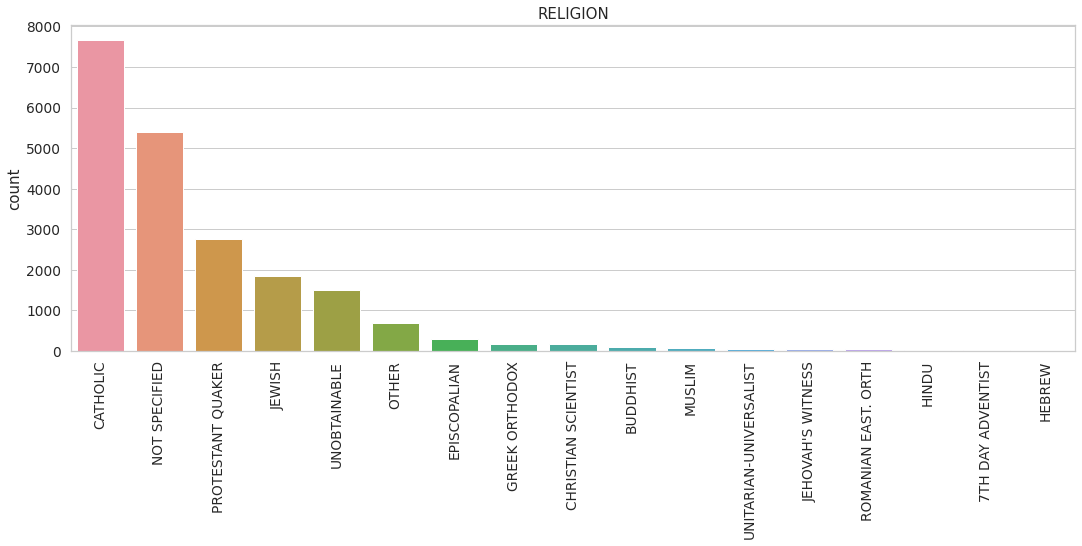

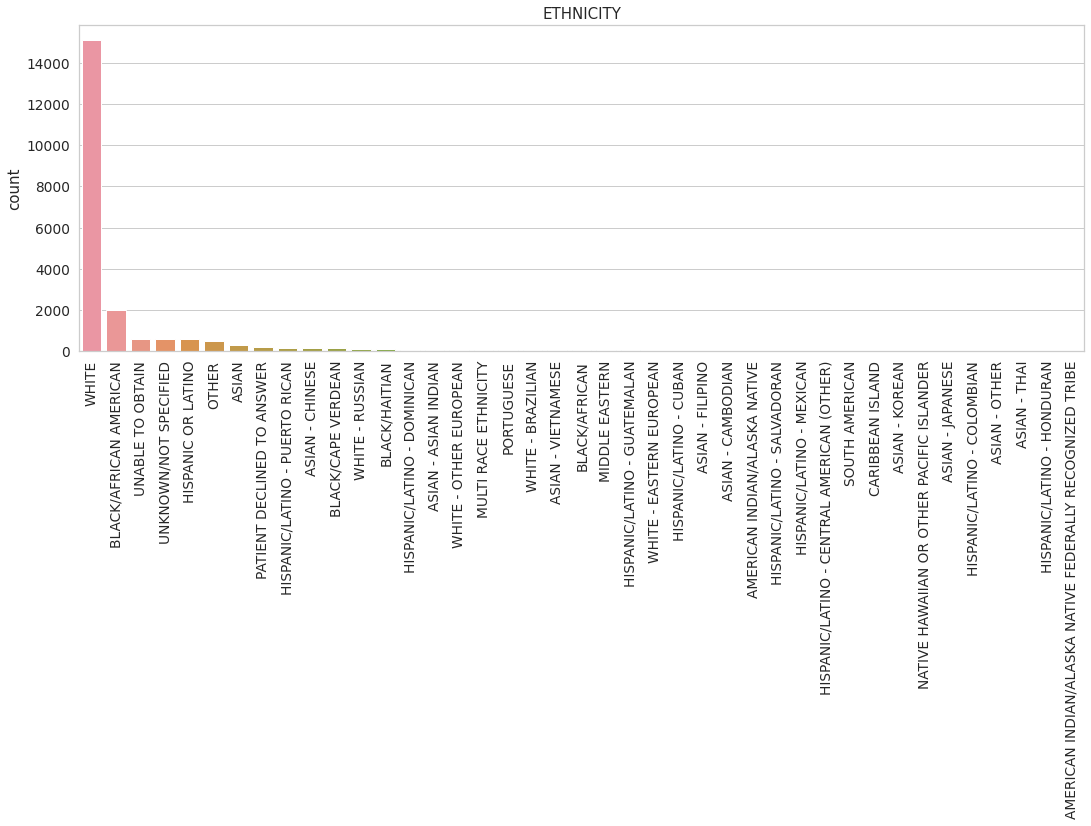

In [48]:
# Visualize counts of categories
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
cat_feats_figs = [cat for cat in cat_feats if cat not in remove]

for c in cat_feats_figs:
  plt.figure().set_size_inches(18, 6)
  ax = sns.countplot(data = df_train_cat, 
                     x = c,
                     order = df_train_cat[c].value_counts().index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
  ax.set_title(str(c))
  ax.set(xlabel='')
  plt.show()

### 3.4.2 Binary Encoding

I now use binary encoding for all categorical variables except `ICD9_diagnosis` and `DIAGNOSIS`. The latter two have too many categories as dimensionality would increase which would be computationally expensive to fit a model and/or pipeline on.

In [49]:
# Instantiate
ce_bin = ce.BinaryEncoder(cols = cat_feats_figs)

# Fit
ce_bin.fit(df_train_cat, y_train)

# Transform
df_train_dumm1 = ce_bin.transform(df_train_cat)
df_test_dumm1 = ce_bin.transform(df_test_cat)

# Remove 'ICD9_diagnosis' and 'DIAGNOSIS'
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
df_train_dumm1 = df_train_dumm1.drop(remove, axis = 1)
df_test_dumm1 = df_test_dumm1.drop(remove, axis = 1)

# Print results
print('Shape: ', df_train_dumm1.shape); df_train_dumm1.head()

Shape:  (20885, 25)


,GENDER_0,GENDER_1,ADMISSION_TYPE_0,ADMISSION_TYPE_1,INSURANCE_0,INSURANCE_1,INSURANCE_2,FIRST_CAREUNIT_0,FIRST_CAREUNIT_1,FIRST_CAREUNIT_2,MARITAL_STATUS_0,MARITAL_STATUS_1,MARITAL_STATUS_2,MARITAL_STATUS_3,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,ETHNICITY_0,ETHNICITY_1,ETHNICITY_2,ETHNICITY_3,ETHNICITY_4,ETHNICITY_5
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,
228357,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
221004,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
296315,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
245557,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
225281,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


### 3.4.3 Weight of Evidence Encoding

Even though binary encoding `ICD9_diagnosis` and `DIAGNOSIS` only adds 24 features to the above dataframe, I prefer to use the method of Weight of Evidence encoding which only adds two features (one for each).

In [50]:
# Set features to transform
remove = ['ICD9_diagnosis', 'DIAGNOSIS']
train_te, test_te = df_train_cat[remove], df_test_cat[remove]

In [51]:
# Instantiate encoder
woe = WOEEncoder()

# Fit
woe.fit(train_te, y_train)

# Transform
df_train_dumm2 = woe.transform(train_te)
df_test_dumm2 = woe.transform(test_te)

# Print results
print('Shape: ', df_train_dumm2.shape); df_test_dumm2.head()

Shape:  (20885, 2)


,ICD9_diagnosis,DIAGNOSIS
icustay_id,,
208169,-1.895816,-1.367087
251754,-2.363916,-1.367087
242171,-0.130324,0.000000
263035,2.472366,0.000000
279388,0.431145,0.000000


### 3.4.4 Concatenate Encoded Categorical Data Frames

In [52]:
df_train_dumm = pd.concat([df_train_dumm2, df_train_dumm1], axis = 1)
df_test_dumm = pd.concat([df_test_dumm2, df_test_dumm1], axis = 1)

### 3.4.5 Imputing NaNs

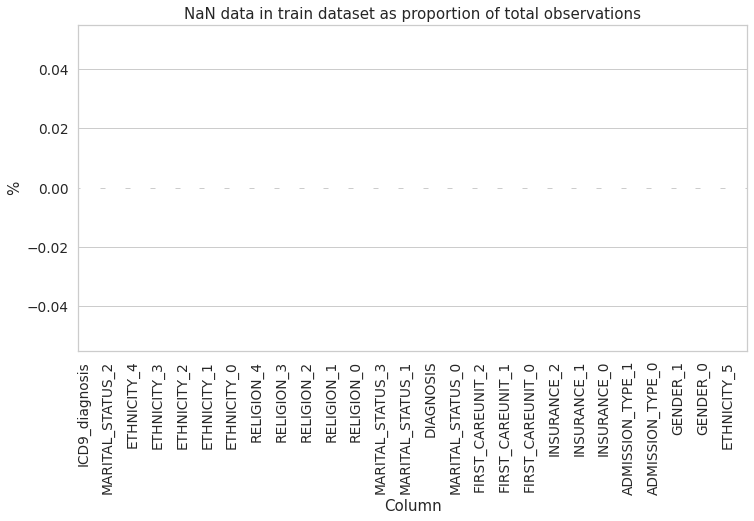

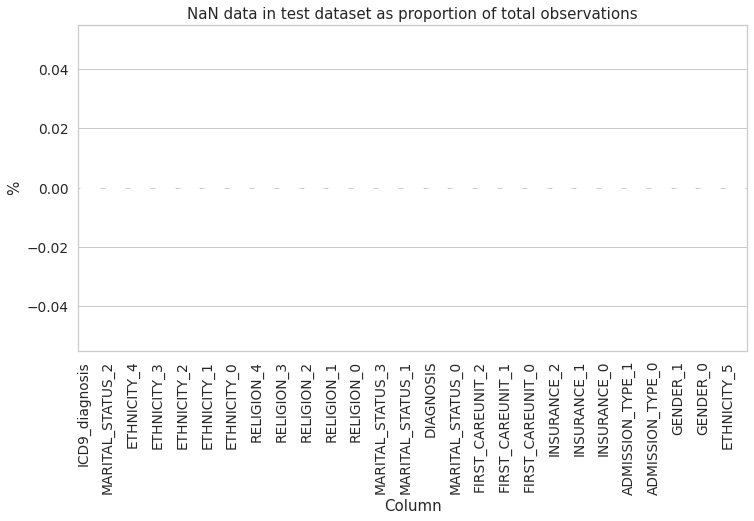

In [53]:
# Investigate missing data
my_plots.missing_plot(df_train_dumm, 'train'); my_plots.missing_plot(df_test_dumm, 'test')

So there are no missing values left for the categorical features.

## 3.5 Concatenate Numerical and Categorical Features

In [54]:
# Concatenate num and cat feats
X_train = pd.concat([df_train_scl, df_train_dumm], axis = 1)
X_test = pd.concat([df_test_scl, df_test_dumm], axis = 1)

In [55]:
# Also Add subject id (to be used for merge)
X_train = pd.concat([X_train, df_train_fillna['subject_id']], axis = 1)
X_test = pd.concat([X_test, df_test_fillna['subject_id']], axis = 1)

## 3.5 Merge Co-Morbidities

Please refer to the auxiliary notebook `comorb_transform.ipynb` ([this GitHub-link](https://github.com/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/comorb_transform.ipynb)) where comorbidities are transformed using the `icd` package in `R`.

In [56]:
# Add comorbidities that are already one-hot encoded
comorb_add = comorb.drop('charlson_score', axis = 1)
comorb_add

,subject_id,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV
1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,10000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
5,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46516,9999,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
46517,99991,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
46518,99992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46519,99995,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [57]:
# Merge comorb on train
merge_train = X_train.merge(comorb_add, 
                            how = 'left', 
                            on = "subject_id",
                            indicator = True)
print(merge_train['_merge'].value_counts())
print(merge_train.isna().any())

both          20885
left_only         0
right_only        0
Name: _merge, dtype: int64
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
                  ...  
Cancer            False
LiverSevere       False
Mets              False
HIV               False
_merge            False
Length: 71, dtype: bool


In [58]:
# Merge comorb on test
merge_test = X_test.merge(comorb_add, how = 'left', on = "subject_id", indicator = True)
print(merge_test['_merge'].value_counts())
print(merge_test.isna().any())

both          5221
left_only        0
right_only       0
Name: _merge, dtype: int64
HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
                  ...  
Cancer            False
LiverSevere       False
Mets              False
HIV               False
_merge            False
Length: 71, dtype: bool


All unique `subject_id`s are found in both the training dataset as well as in the the comorbidities data.

In [59]:
# Set indices from X_train and X_train respectively
merge_train = merge_train.set_index(X_train.index)
merge_test = merge_test.set_index(X_test.index)

In [60]:
# Drop merge indicator and id
merge_train = merge_train.drop(['subject_id', '_merge'], axis = 1)
merge_test = merge_test.drop(['subject_id', '_merge'], axis = 1)

# rename
X_train = merge_train
X_test = merge_test

In [61]:
print("Shape: ", X_train.shape)
X_train.head(7)

Shape:  (20885, 69)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,ICD9_diagnosis,DIAGNOSIS,GENDER_0,GENDER_1,ADMISSION_TYPE_0,ADMISSION_TYPE_1,INSURANCE_0,INSURANCE_1,INSURANCE_2,FIRST_CAREUNIT_0,FIRST_CAREUNIT_1,FIRST_CAREUNIT_2,MARITAL_STATUS_0,MARITAL_STATUS_1,MARITAL_STATUS_2,MARITAL_STATUS_3,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,ETHNICITY_0,ETHNICITY_1,ETHNICITY_2,ETHNICITY_3,ETHNICITY_4,ETHNICITY_5,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
228357,1.297567,1.900397,2.341278,-0.975958,-0.995501,-0.751956,-0.195461,0.084999,-0.121493,0.188658,-0.473959,-0.275898,0.862461,0.353561,0.873328,-1.284103,-0.605516,-1.112702,-0.136163,-0.479308,-0.483297,0.119905,0.516605,0.487878,0.423830,-0.113517,-0.434535,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
221004,-0.450986,0.227521,-0.395788,-0.120383,-1.247251,-0.743192,0.392303,-0.744659,0.201782,0.118964,-0.836472,-0.252815,0.302566,-1.079937,-0.760345,0.385363,-1.022247,-0.463154,0.945036,0.382939,0.939604,-0.107510,-0.853947,-0.798014,-1.293388,0.000000,0.968288,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296315,0.759551,-0.346037,0.424957,-0.177421,-0.533959,-0.380797,0.056438,-1.107635,-0.516797,0.537129,-0.691467,-0.424786,0.302566,-1.079937,-0.801602,0.537133,-0.674971,-0.140938,1.215336,0.382939,1.343015,0.716870,1.768449,1.753313,0.336600,0.888246,-0.229785,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0
245557,0.423291,1.087857,0.892876,-0.405575,-0.659834,-0.728843,-1.203058,0.033146,-1.875188,-0.577978,-0.473959,-1.334091,0.022618,1.149949,2.022432,0.385363,2.589426,1.792360,-1.757961,0.382939,-0.763367,0.034625,-0.465444,-0.308386,0.758037,-0.572157,0.457463,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
225281,-0.128680,-0.117213,-0.159835,-0.042719,0.104198,0.046436,-0.166670,-0.004847,-0.208148,-0.078313,0.048214,-0.107199,0.072214,0.022273,0.056059,-0.061347,-0.074133,-0.091433,-0.072348,-0.023293,-0.080435,-0.278071,-0.487028,-0.575456,1.036657,-1.131773,0.321661,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0
287519,0.019779,1.183450,0.833734,0.906307,0.179333,0.555008,1.315933,-0.018708,1.114289,1.094682,-0.256452,0.828847,-0.537278,-0.761382,-0.851654,-0.069946,-0.605516,-0.265879,0.674737,0.382939,0.862119,-0.420206,-0.433069,-0.766856,-0.849887,-0.130324,0.000000,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
231164,-0.383734,0.514299,0.148065,0.735192,-0.114375,0.176910,0.392303,-0.848367,-0.555072,0.885600,-0.546462,0.106503,0.022618,-0.602105,-0.799240,-1.132333,1.130866,0.082641,0.404437,0.382939,0.663128,-0.135937,0.236020,0.552172,0.377136,0.000000,0.321661,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [62]:
print("Shape: ", X_test.shape)
X_test.head(7)

Shape:  (5221, 69)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,ICD9_diagnosis,DIAGNOSIS,GENDER_0,GENDER_1,ADMISSION_TYPE_0,ADMISSION_TYPE_1,INSURANCE_0,INSURANCE_1,INSURANCE_2,FIRST_CAREUNIT_0,FIRST_CAREUNIT_1,FIRST_CAREUNIT_2,MARITAL_STATUS_0,MARITAL_STATUS_1,MARITAL_STATUS_2,MARITAL_STATUS_3,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,ETHNICITY_0,ETHNICITY_1,ETHNICITY_2,ETHNICITY_3,ETHNICITY_4,ETHNICITY_5,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208169,-0.787246,-0.728408,0.004220,-0.804843,0.095417,-1.236719,-0.363394,-0.589098,-0.953039,-0.229507,-0.183949,-0.846714,-1.657069,-0.602105,-1.738289,-1.026095,0.964173,1.082810,0.539587,0.382939,0.996467,-0.505486,0.516605,-0.092856,1.172632,-1.895816,-1.367087,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
251754,1.432071,1.900397,1.950365,-1.032997,-0.324167,-1.073878,-0.195461,-0.122415,0.278583,-0.438590,6.123769,0.665029,2.262201,1.946337,1.847383,0.005939,2.519971,1.792360,0.269287,0.382939,0.342892,1.285408,8.998923,5.623377,-0.899317,-2.363916,-1.367087,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
242171,2.440851,1.279043,2.126268,0.107770,-0.575917,-0.175031,0.560236,-0.640952,0.380736,0.258352,-0.727718,-0.023700,1.142409,-0.124272,0.801529,1.523636,2.172695,2.698814,0.134137,0.382939,-0.419107,-0.192790,-0.357526,-0.352898,-1.286546,-0.130324,0.000000,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
263035,0.154283,-0.011462,-0.101394,-1.090035,0.724792,0.469216,-0.447360,0.551682,0.031146,-0.717367,0.106061,0.080128,-0.537278,-0.283549,-1.295158,-0.145831,0.436313,0.292294,-0.271313,0.382939,-0.683209,0.660016,-0.055357,0.186806,1.344354,2.472366,0.000000,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
279388,1.028559,0.896671,0.876089,-0.291498,-0.282209,-0.507678,0.644202,2.314707,0.937444,0.676517,1.012342,0.792507,-1.377122,0.194284,1.344405,0.081824,-0.188784,-0.180393,-0.676762,0.382939,-0.371482,-0.931890,0.710857,0.370416,-0.611119,0.431145,0.000000,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
262988,-2.065034,-1.588745,-2.226185,-1.831534,-2.925585,-2.698158,-0.279428,-1.315050,-0.856299,-0.787061,-1.452743,-1.748908,-0.257330,-1.239215,-1.378284,-1.739412,-0.952792,-1.600775,0.674737,0.382939,0.846713,-2.097392,-0.476236,-1.362756,-2.740708,0.000000,0.000000,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
291777,2.239095,2.282768,2.118298,1.362614,1.647876,1.332247,1.148000,1.122073,1.303198,1.094682,5.072483,1.788791,0.862461,1.627782,0.161572,1.599520,1.894874,2.280995,0.674737,0.382939,0.972839,0.802151,0.225228,0.503951,-1.602111,-0.928832,0.120990,1,0,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3.6 Principal Component Analysis

In [63]:
'''
def make_scree_plot(array):
  plt.plot(np.cumsum(array.explained_variance_ratio_ * 100))
  plt.xlabel("Number of components (Dimensions)")
  plt.ylabel("Explained variance (%)")
  plt.xticks(np.arange(0, 400, step=10), rotation = 'vertical')
  plt.grid(visible = True)

  fig = plt.gcf()
  fig.set_size_inches(25, 5)

  return plt.show()
'''

'\ndef make_scree_plot(array):\n  plt.plot(np.cumsum(array.explained_variance_ratio_ * 100))\n  plt.xlabel("Number of components (Dimensions)")\n  plt.ylabel("Explained variance (%)")\n  plt.xticks(np.arange(0, 400, step=10), rotation = \'vertical\')\n  plt.grid(visible = True)\n\n  fig = plt.gcf()\n  fig.set_size_inches(25, 5)\n\n  return plt.show()\n'

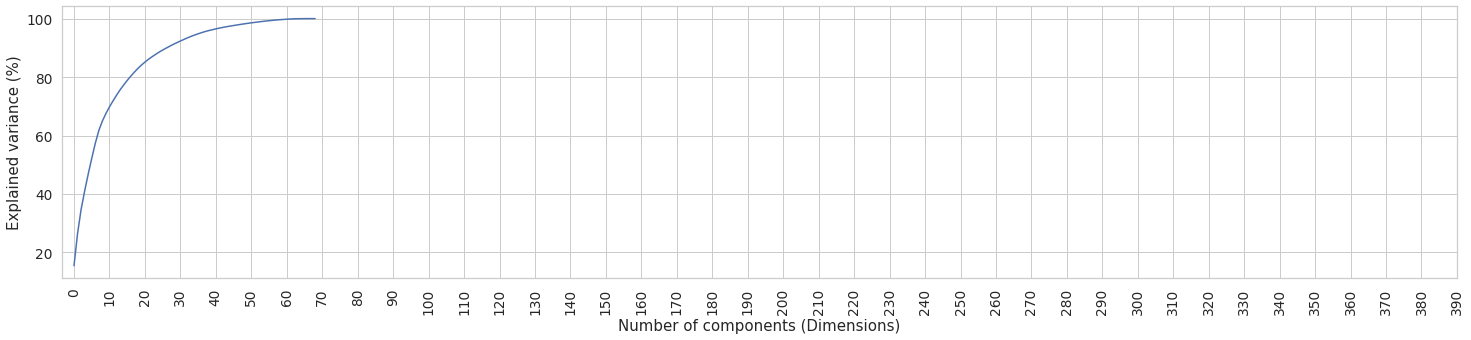

In [64]:
# Apply PCA to training data
pca = PCA(n_components = None)
pca.fit(X_train)

# Make scree plot
my_plots.make_scree_plot(pca)

No real elbow is apparent. I will choose 30 components

In [65]:
# Instantiate PCA with 30 components
pca = PCA(n_components=30)

# Fit to training data
X_pca = pca.fit(X_train)

# Transform train and test with the pipeline fittes on train data
X_pca_train, X_pca_test = pca.transform(X_train), pca.transform(X_test)

# pd.dataframes
X_pca_train, X_pca_test = pd.DataFrame(X_pca_train, index = X_train.index), pd.DataFrame(X_pca_test, index = X_test.index)

# **4. $k$-NN Estimation**

## 4.1 Dealing with Class Imbalance

In [69]:
y_train.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [70]:
# RandomOverSampler
ros = RandomOverSampler(sampling_strategy = 'auto')

X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_pca_ros, y_pca_ros = ros.fit_resample(X_pca_train, y_train)

In [71]:
y_ros.value_counts()

0    18540
1    18540
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

## 4.2 Pipeline and Grid Search

In [ ]:
# Set pipeline
KNN = KNeighborsClassifier()

#n_neighbors = [2, 3, 5, 10]
#n_neighbors = [2, 15, 20, 25]
#n_neighbors = [25, 30, 35, 40, 45, 60, 70, 90]
n_neighbors = [90, 130, 150, 170, 200, 250, 300, 350, 400]

leaf_size = [1, 20, 40]
p =  [1,2]
weights = ['uniform', 'distance']
metric = ['minkowski', 'chebyshev']
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]


# For sort of faster run time
'''
n_neighbors = [130, 150, 170]    #<- faster
leaf_size = [20]
p =  [1,2]
weights = ['distance']
metric = ['chebyshev']
algorithm = ["brute"]
'''

# Pipeline
pipe = Pipeline(steps=[("KNN", KNN)])

parameters = dict(KNN__n_neighbors = n_neighbors,
                  KNN__algorithm = algorithm,
                  KNN__leaf_size = leaf_size,
                  KNN__p = p,
                  KNN__weights = weights,
                  KNN__metric = metric)

In [ ]:
%%time 
# Print of NN candidates
print("NN Candidates: " + str(n_neighbors))
print("Algorithm Candidates: " + str(algorithm))
print("Leafes Candidates: " + str(leaf_size))
print("p Candidates: " + str(p))
print("Weights Candidates: " + str(weights))
print("Metric Candidates: " + str(metric))

# Instantiate grid search and pipe. RandomizedSearchCV() is used to save computing time compared to GridSearchCV()
clf = RandomizedSearchCV(pipe, parameters,
                         scoring = 'roc_auc', 
                         cv = 5, 
                         n_jobs = -1)
'''
clf = GridSearchCV(pipe, parameters, 
                   scoring = "roc_auc", 
                   cv = 5, 
                   n_jobs = -1)
'''

# Run grid search
clf.fit(X_ros, y_ros)
#clf.fit(X_pca_ros, y_pca_ros)

# Save best parameters
best_nn = clf.best_estimator_.get_params()['KNN__n_neighbors']
best_alg = clf.best_estimator_.get_params()['KNN__algorithm']
best_leaf_size = clf.best_estimator_.get_params()['KNN__leaf_size']
best_p = clf.best_estimator_.get_params()['KNN__p']
best_weights = clf.best_estimator_.get_params()['KNN__weights']
best_metric = clf.best_estimator_.get_params()['KNN__metric']


print(clf.best_params_ )

## 4.3 Run Model

Now, using the best parameters from the grid search the model is fitted on the training data.

In [74]:
%%time 
# Print hyperparameters from grid search
'''
print('Best NN: ' + str(best_nn)); print('Best Algorithm: ' + str(best_alg)); print('Best Leaf Size: ' + str(best_leaf_size))
print('Best p: ' + str(best_p)); print('Best Weights: ' + str(best_weights)); print('Best Metric: ' + str(best_metric))

# Instantiate

knn = KNeighborsClassifier(n_neighbors = best_nn, 
                           algorithm = best_alg,
                           leaf_size = best_leaf_size,
                           p = best_p,
                           weights = best_weights,
                           metric = best_metric)
'''

knn = KNeighborsClassifier(n_neighbors = 150, 
                           algorithm = 'brute',
                           leaf_size = 20,
                           p = 1,
                           weights = 'distance',
                           metric = 'chebyshev')


# Fit (using oversampled data)
knn.fit(X_ros, y_ros)
#knn.fit(X_pca_ros, y_pca_ros)

# Predict (using original, unbalanced data)
'''
y_hat = knn.predict(X_train)
p_hat = knn.predict_proba(X_train)[:,1]

# Plot p_hat distribution
my_plots.p_hat_plot(p_hat)
'''

CPU times: user 31.4 ms, sys: 5.81 ms, total: 37.2 ms
Wall time: 75.3 ms


## 4.4 Model Evaluation

### 4.4.1 Cross-Validation

### 4.4.2 AUC

# **5. SVM Estimation**



---


<font color=red>**NOTE TO SELF:** Here in SVM estimation will probably benefit the most of learning how to run pipeline in AWS due to computational expense / long runtime.<br>
Resource of how to run `scikit-learn` on `AWS`: [https://towardsdatascience.com/deploying-a-scikit-learn-model-on-aws-using-sklearn-estimators-local-jupyter-notebooks-and-the-d94396589498](https://towardsdatascience.com/deploying-a-scikit-learn-model-on-aws-using-sklearn-estimators-local-jupyter-notebooks-and-the-d94396589498).
 </font>


---



## 5.1 Setting Data and Random Sample

For testing code below

In [ ]:
y_train, X_train = y_train, X_train

In [ ]:
# Random sample while building code
y_random, X_random = y_train.sample(frac = 0.01), X_train.sample(frac = 0.01)

print(X_random.shape); print(X_random.head(3) )
print(y_random.shape); print(y_random.head(4) )

(209, 59)
            HeartRate_Min  HeartRate_Max  ...  Mets  HIV
icustay_id                                ...           
295931           2.792880       1.149718  ...     0    0
296932          -0.334478      -0.668801  ...     0    0
203349          -0.547707      -0.719315  ...     0    0

[3 rows x 59 columns]
(209,)
icustay_id
284204    0
277206    0
216069    1
204145    0
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


## 5.2 Pipeline and GridSearch

I am using the Bayesian optimization over hyper parameters searcher `BayesSearchCV` from `skopt` which has not been covered in class but which yields me the best results for given computational run time.

In [ ]:
%%time
# Inspired by mano:

# Run time 1h 6m 21s

MySvc = SVC(kernel='rbf')

grid_values = {'C':[0.1, 1, 10], 'gamma':[0.25,0.5,0.75]} # automatic gamma will be gamma=1/num_features

#grid_svc_acc = GridSearchCV(MySvc, param_grid = grid_values,scoring = 'accuracy', cv=5)
grid_svc_acc = RandomizedSearchCV(MySvc, param_distributions = grid_values,scoring = 'accuracy', cv=5)

target, df = y_train, X_train  #<- full sample
grid_svc_acc.fit(df, target)

# Results score achieved during the GridSearchCV
print('GridSearch CV best score: {:.4f}\n'.format(grid_svc_acc.best_score_))
print('\n Parameters that give the best results:','\n', (grid_svc_acc.best_params_))
print('\n\n Estimator that was chosen by the search:','\n', (grid_svc_acc.best_estimator_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


GridSearch CV best score: 0.8877


 Parameters that give the best results: 
 {'gamma': 0.25, 'C': 0.1}


 Estimator that was chosen by the search: 
 SVC(C=0.1, gamma=0.25)


In [ ]:
%%time
# Run time: 8 min
Svc = SVC(kernel='rbf', gamma = 0.25, C = 0.1, probability = True)
Svc.fit(df, target)
y_pred_out = Svc.predict_proba(X_test)[:,1]

In [ ]:
# Reweight predicted probabilities
#y_pred_out = y_pred_out.apply(my_postest.reweight,args=(q1,r1))
#y_pred_out

In [ ]:
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_pred_out})
test_predictions_submit.to_csv("test_predictions_submit_svm_manopipeline.csv", index = False) # Kaggle accuracy: .80322

In [ ]:
# Set pipeline

# Declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 
                'kernel':['linear', 'poly', 'rbf'], 
                #'degree': [2,3,4], 
                #'gamma':[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                #'gamma':[0.01, 0.05, 0.1, 0.5, 0.9],
                'gamma':[0.01, 0.05, 0.1],
                'degree': [2], 
                'probability':[True], 'class_weight':['balanced'] 
                } ]

# Instantiate classifier                
svc=SVC() 

# Instantiate grid search
svc_grid = BayesSearchCV(estimator = svc,
                         search_spaces = parameters,
                         scoring ='roc_auc',
                         cv = 5,
                         n_iter = 25,
                         n_jobs = -1,
                         verbose = 0)

# Print total iterations to search over
print('Total iterations in grid:', svc_grid.total_iterations)

'''
# Previous grid specifications

svc_grid = RandomizedSearchCV(estimator = svc, param_distributions = parameters,
                           scoring ='roc_auc', cv = 5, verbose = 0)
svc_grid = GridSearchCV(estimator = svc, param_grid = parameters, scoring ='roc_auc',
                           class_weight = 'balanced', probability = True, cv = 5, verbose=0)
'''

Total iterations in grid: 25


"\n# Previous grid specifications\n\nsvc_grid = RandomizedSearchCV(estimator = svc, param_distributions = parameters,\n                           scoring ='roc_auc', cv = 5, verbose = 0)\nsvc_grid = GridSearchCV(estimator = svc, param_grid = parameters, scoring ='roc_auc',\n                           class_weight = 'balanced', probability = True, cv = 5, verbose=0)\n"

Run grid:

In [ ]:
%%time
# Redefine data for search
#target, df = y_random, X_random #<- random sample for code testing
target, df = y_train, X_pca_train #<- PCA-sample
#target, df = y_train, X_train  #<- full sample

# Fit grid
svc_grid.fit(df, target)

# Results score achieved during the GridSearchCV
print('GridSearch CV best score: {:.4f}\n'.format(svc_grid.best_score_))
print('\n Parameters that give the best results:','\n', (svc_grid.best_params_))
print('\n\n Estimator that was chosen by the search:','\n', (svc_grid.best_estimator_))

best parameters: {'probability': True, 'kernel': 'poly', 'gamma': 0.3, 'degree': 3, 'class_weight': 'balanced', 'C': 1000}
best score:      0.62479 (+/-0.10436)


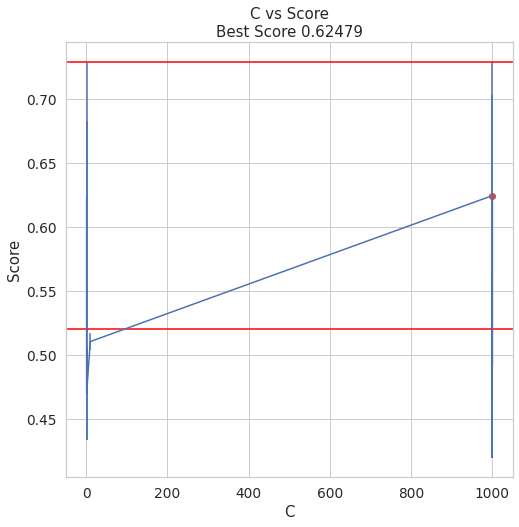

best parameters: {'probability': True, 'kernel': 'poly', 'gamma': 0.3, 'degree': 3, 'class_weight': 'balanced', 'C': 1000}
best score:      0.62479 (+/-0.10436)


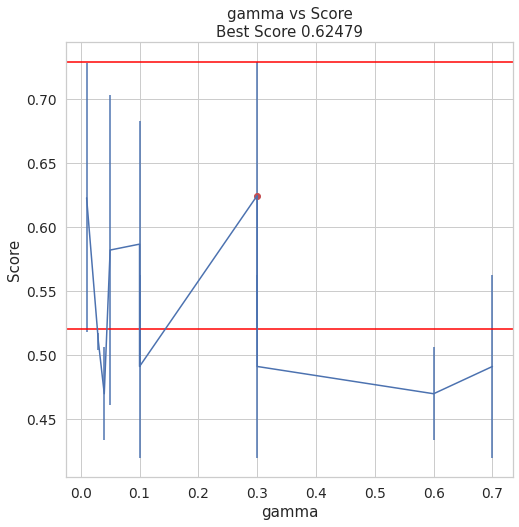

best parameters: {'probability': True, 'kernel': 'poly', 'gamma': 0.3, 'degree': 3, 'class_weight': 'balanced', 'C': 1000}
best score:      0.62479 (+/-0.10436)


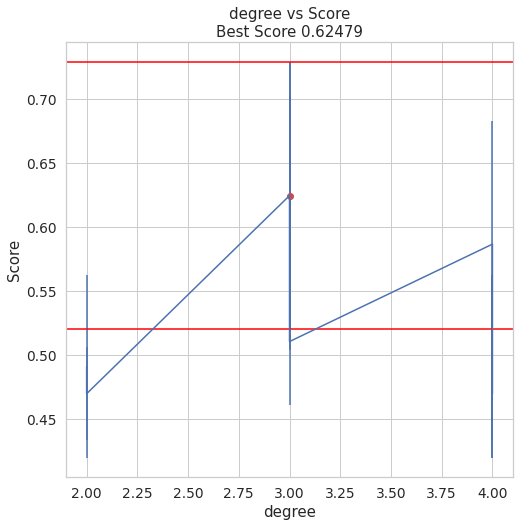

best parameters: {'probability': True, 'kernel': 'poly', 'gamma': 0.3, 'degree': 3, 'class_weight': 'balanced', 'C': 1000}
best score:      0.62479 (+/-0.10436)


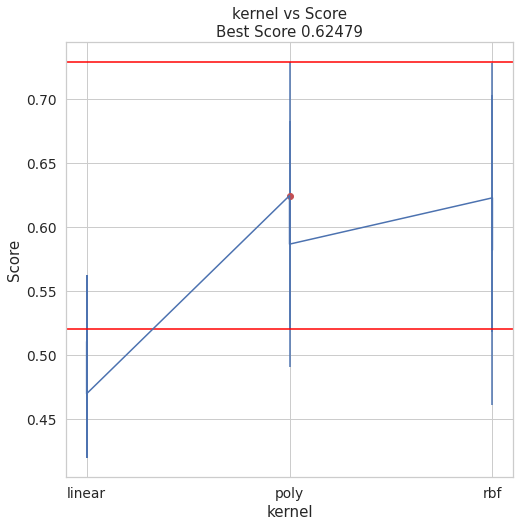

In [ ]:
# Visualizing search from pipeline
score_list = ["C", "gamma", "degree", "kernel"]

for x in range(len(score_list)):
  util.GridSearch_table_plot(svc_grid, 
                             score_list[x], 
                             negative=False, 
                             display_all_params=False, 
                             table = False)

## 5.3 Run Model

# **End1. Export $k$-NN Predictions for Kaggle Competition**

Link to Kaggle competition: [https://www.kaggle.com/c/cml2-probability-of-death-with-k-nn](https://www.kaggle.com/c/cml2-probability-of-death-with-k-nn)

In [75]:
%%time
# Predict probabilities from test set
p_hat_test = knn.predict_proba(X_test)[:,1]
#p_hat_test = knn.predict_proba(X_pca_test)[:,1]

# Save as pd.DataFrame
kaggle = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": p_hat_test})
#kaggle = pd.DataFrame({"icustay_id": X_pca_test.index, "HOSPITAL_EXPIRE_FLAG": p_hat_test})


# Calculate parameters for reweight functions
'''
q1 = y_train.sum()/len(y_train)
r1 = y_ros.sum()/len(y_ros)
'''
q1 = y_train.sum()/len(y_train)
r1 = y_pca_ros.sum()/len(y_pca_ros)

# Reweight predicted probabilities
kaggle["HOSPITAL_EXPIRE_FLAG"] = kaggle["HOSPITAL_EXPIRE_FLAG"].apply(my_postest.reweight,args=(q1,r1))
kaggle

CPU times: user 22.8 s, sys: 46.2 ms, total: 22.8 s
Wall time: 26.4 s


In [77]:
# Save strings for filename
date_filename = str(datetime.now().strftime('%Y_%m_%d_%H_%M'))
'''
bestNNstr = str(best_nn)
bestALGstr = str(best_alg)
bestLEAFstr =  str(best_leaf_size)
bestPstr = str(best_p)
bestWEIGHTstr =  str(best_weights)
bestMETRICstr = str(best_metric)


# Save .csv file
kaggle.to_csv("preds/preds-" + date_filename + '-'
                               + 'NN_' + bestNNstr + '-'
                               + 'ALG_' + bestALGstr + '-'
                               + 'LEAF_' + bestLEAFstr + '-'
                               + 'P_' + bestPstr + '-'
                               + 'WEIGHT_' + bestWEIGHTstr + '-'
                               + 'METRIC_' + bestMETRICstr 
                               + ".csv", index = False)
'''
kaggle.to_csv("preds/preds-" + date_filename + '-' ".csv", index = False)

# **End2. Export SVM Predictions for Kaggle Competition**

Link to Kaggle competition: [https://www.kaggle.com/c/cml2-probability-of-death-with-svm/](https://www.kaggle.com/c/cml2-probability-of-death-with-svm/)